## Import libraries

In [1]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
import sys
import os

os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'
sys.path.append('/Users/riccardo/Documents/GitHub/COVID19Classification/')
print(sys.version)

from Modules import Parameters, DataPreprocessing as DP

3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]
3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]


## Import data

In [2]:
# Import data of hostpitalized patients
file_name = 'DataInpatients_CCIMasked.xlsx'
path_import = Parameters.path_datasets + file_name
DataInpatients_0 = pd.read_excel(path_import, engine='openpyxl')
DataInpatients_0.drop(columns=['Unnamed: 0'], inplace=True)
print('Shape inpatients data:', DataInpatients_0.shape)

# Import data of non-hostpitalized patients
file_name = 'DataOutpatients.xlsx'
path_import = Parameters.path_datasets + file_name
DataOutpatients_0 = pd.read_excel(path_import, engine='openpyxl')
DataOutpatients_0.drop(columns=['Unnamed: 0'], inplace=True)
print('Shape outpatients data:', DataOutpatients_0.shape)

Shape inpatients data: (826, 94)
Shape outpatients data: (462, 98)


## Preprocessing

### Format nans

In [52]:
# nan/nat to none
DataInpatients_1 = DataInpatients_0.copy()
DataInpatients_1 = DataInpatients_1.where(DataInpatients_1.notnull().values, -1e100)
DataInpatients_1 = DataInpatients_1.where(DataInpatients_1.values!=-1e100, np.nan)

DataOutpatients_1 = DataOutpatients_0.copy()
DataOutpatients_1 = DataOutpatients_1.where(DataOutpatients_1.notnull().values, -1e100)
DataOutpatients_1 = DataOutpatients_1.where(DataOutpatients_1.values!=-1e100, np.nan)

### Neutro, Baso, Euso

In [53]:
if 'NeutroBaEu/uL' not in DataInpatients_1.columns:
    new_idx = DataInpatients_1.columns.get_loc('WBC/uL') + 1
    v = DataInpatients_1['WBC/uL'].values - (DataInpatients_1['Mono/uL'].values + DataInpatients_1['Linfo/uL'].values)
    v[v<0] = 0
    DataInpatients_1.insert(loc=new_idx, column='NeutroBaEu/uL', value=v)

    new_idx = DataOutpatients_1.columns.get_loc('WBC/uL') + 1
    v = DataOutpatients_1['WBC/uL'].values - (DataOutpatients_1['Mono/uL'].values + DataOutpatients_1['Linfo/uL'].values)
    v[v<0] = 0
    DataOutpatients_1.insert(loc=new_idx, column='NeutroBaEu/uL', value=v)

### $\Delta t_{\mathrm{ons}}$ 

In [54]:
# Dates
dates = [date for date in DataInpatients_1.columns if 'date#' in date]

if 'delta_onset' not in DataInpatients_1.columns:
    
    # Find time elapsed since ref. timepoint for each date
    ref_date_str = '01-01-2020'
    ref_date = pd.Timestamp(ref_date_str)
    d_dates = {}
    for date in dates:
        d_dates[date] = np.array([(element-ref_date).days if pd.notnull(element) else np.nan for element in DataInpatients_1[date]])
    d_dates_df = pd.DataFrame(d_dates, columns=dates, index=DataInpatients_1['ID'])

    # Add delta_onset column to DataInpatients_1
    date_flowcyt_exam = d_dates_df['date#flowcyt_exam'].values
    date_onset = d_dates_df['date#onset'].values    
    delta_onset_df = pd.DataFrame(date_flowcyt_exam - date_onset, columns=['delta_onset'], index=d_dates_df.index)
    v = delta_onset_df.values
    DataInpatients_1['delta_onset'] = v
    DataOutpatients_1['delta_onset'] = np.nan
    print('N. delta_onset data:', sum(DataInpatients_1['delta_onset'].notna()))

N. delta_onset data: 732


### Outpatients categories: no covid, no hospitalization

In [55]:
columns_covid_data = DataInpatients_1.columns

mask_noCovid = DataOutpatients_1['COVID ']==0
Data_noCovid = DataOutpatients_1.loc[mask_noCovid, columns_covid_data].copy()
print('Data no covid shape:', Data_noCovid.shape)

mask_Covid = mask_noCovid==False
mask_noAdmission =  DataOutpatients_1['Admission']==0
Data_noAdmission = DataOutpatients_1.loc[mask_Covid & mask_noAdmission, columns_covid_data].copy()
print('Data no admission shape:', Data_noAdmission.shape)

DataOutpatients = DataOutpatients_1.loc[mask_noCovid | mask_noAdmission, columns_covid_data].copy()
print('Data control shape:', DataOutpatients.shape)

Data no covid shape: (95, 96)
Data no admission shape: (367, 96)
Data control shape: (462, 96)


### Age masking (inpatients only)

In [56]:
## Age range
min_age = Parameters.age_min # int>=0
max_age = Parameters.age_max # int>lower_bound
age_masking = (min_age>0) | (max_age<150)

## Masking
age = np.round(DataInpatients_1['age'].values)
title = 'Age between %d and %d' % (min_age, max_age)
age_mask = (age >= min_age) & (age < max_age)
DataInpatients_2 = DataInpatients_1.loc[age_mask, :].copy()

print('Min. age:', np.round(min(DataInpatients_2['age'])))
print('Max. age:', np.round(max(DataInpatients_2['age'])))
print('Title:', title)
print('Data inpatients shape:', DataInpatients_2.shape)
print('Data outpatients shape:', DataOutpatients.shape)

Min. age: 30.0
Max. age: 98.0
Title: Age between 30 and 100
Data inpatients shape: (816, 96)
Data outpatients shape: (462, 96)


### $\Delta t_{\mathrm{onset}}$ masking (inpatients only)

In [57]:
## delta_onset range
min_donset = Parameters.donset_min # int>=0
max_donset = Parameters.donset_max # int>lower_bound
donset_masking = (min_donset>=0) | (max_donset<=30)

## Masking
donset = np.round(DataInpatients_2['delta_onset'].values)
donset_mask = (donset >= min_donset) & (donset <= max_donset)
DataInpatients_3 = DataInpatients_2.loc[donset_mask, :].copy()

print('Min. donset:', np.round(min(DataInpatients_3['delta_onset'])), '(>=%d)'%min_donset)
print('Max. donset:', np.round(max(DataInpatients_3['delta_onset'])), '(<=%d)'%max_donset)
print('Data inpatients shape:', DataInpatients_3.shape)
print('Data outpatients shape:', DataOutpatients.shape)

Min. donset: 1.0 (>=0)
Max. donset: 29.0 (<=30)
Data inpatients shape: (711, 96)
Data outpatients shape: (462, 96)


### Outliers removal

In [48]:
# Variables of interest
immunecells_set = Parameters.immunecells_set
cytokines_set = Parameters.cytokines_set
demographics_set = Parameters.demographics_set
scores_set = Parameters.scores_set
biomarkers_set = Parameters.biomarkers_set
output_set = Parameters.output_set
all_set = Parameters.all_set

# Final dataset
DataInpatients = DataInpatients_3.copy()

std = StandardScaler()
ptr = PowerTransformer()
z_score_th = Parameters.z_score_th
for name in all_set:
    z = ptr.fit_transform(std.fit_transform(DataInpatients[name].values.reshape(-1, 1)))
    is_outlier = abs(z) > z_score_th
    n_outliers = sum(is_outlier)
    if n_outliers:
        DataInpatients[name].where(is_outlier.reshape(-1,)==False, inplace=True)

## Export preprocessed data

In [51]:
file_name = 'DataInpatients_CCIMasked_preprocessed.xlsx'
path = Parameters.path_datasets + file_name
DataInpatients.to_excel(path)

file_name = 'DataOutpatients_preprocessed.xlsx'
path = Parameters.path_datasets + file_name
DataOutpatients.to_excel(path)

Coeff. pca: [[-6.23108653 -0.58421279 -0.01959137 -0.22351425  0.00729014]]
Coeff.: [[ 4.41402467  4.42409518 -0.02597079 -0.40151098 -0.0046978 ]]
[-1.23041835]


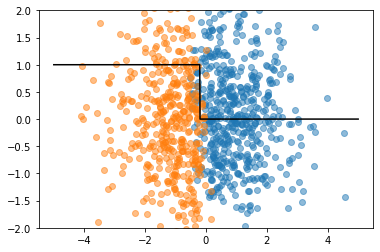

In [104]:
# Check LR on components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

x_1 = np.random.normal(0, 2, (1000, 1))
x_2 = x_1 + np.random.normal(0, 0.05, (1000, 1))
X_low_var =  np.random.normal(0, 0.005, (1000, 3))
X = np.concatenate((x_1, x_2, X_low_var), axis=1)
x_1_max = max(x_1)
y = np.array([np.random.binomial(1, min(1, 6*max(0, 0.25+el)/x_1_max), size=1) for el in x_1]).reshape(-1,)
X_std = StandardScaler().fit_transform(X)
model = PCA().fit(X_std)
X_pca = model.transform(X_std)

LR = LogisticRegression()
LR.fit(X_pca, y)
coefficients_LR = LR.coef_
print('Coeff. pca:', coefficients_LR)
print('Coeff.:', model.inverse_transform(coefficients_LR))
bias_LR = LR.intercept_
print(bias_LR)

plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], alpha=0.5)
v = np.linspace(-5, 5, 1000)
plt.plot(v, bias_LR+coefficients_LR[0, 0]*v>0, color='black')
plt.ylim([-2, 2])

plt.show()

In [105]:
mask_components = model.explained_variance_ratio_.ravel()<0.05
model.components_[mask_components] = 0

X_pca_topcomp = model.transform(X_std)
LR = LogisticRegression()
LR.fit(X_pca_topcomp, y)
coefficients_LR = LR.coef_
print('Coeff. pca:', coefficients_LR)
print('Coeff.:', model.inverse_transform(coefficients_LR))
bias_LR = LR.intercept_
print(bias_LR)

Coeff. pca: [[-6.23109883 -0.58422015 -0.01957818 -0.22351425  0.        ]]
Coeff.: [[ 4.4191884   4.41894909 -0.02596371 -0.40151504 -0.00470951]]
[-1.23041365]


In [107]:
np.hstack((np.ones((3, 4)), np.zeros((3, 2))))

array([[1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.]])